# Q-Learning

In [1]:
!pip install gym_anytrading

## 1. Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv, Actions, Positions
from gym_anytrading.datasets import STOCKS_GOOGL

## 2. Discretizer Class

In [3]:
# Define discretization parameters
class Discretizer:
    def __init__(self, lower_bounds, upper_bounds, num_bins):
        """
        Initialize the discretizer for continuous state space
        
        Args:
            lower_bounds: Lower bounds for each dimension of the observation space
            upper_bounds: Upper bounds for each dimension of the observation space
            num_bins: Number of bins for each dimension
        """
        self.lower_bounds = np.array(lower_bounds)
        self.upper_bounds = np.array(upper_bounds)
        self.num_bins = np.array(num_bins)
        self.bin_sizes = (upper_bounds - lower_bounds) / num_bins
    
    def discretize(self, observation):
        """
        Convert a continuous observation to a discrete state
        
        Args:
            observation: Continuous observation from the environment
            
        Returns:
            A tuple representing the discretized state
        """
        # Clip the observation to be within bounds
        clipped_obs = np.clip(observation, self.lower_bounds, self.upper_bounds)
        
        # Calculate the bin indices for each dimension
        bin_indices = np.floor((clipped_obs - self.lower_bounds) / self.bin_sizes).astype(int)
        
        # Ensure indices are within valid range
        bin_indices = np.clip(bin_indices, 0, self.num_bins - 1)
        
        # Convert multi-dimensional indices to a single index
        # We'll use a tuple for the state representation
        return tuple(map(int, bin_indices.flatten()))

## 3.1. Q-Learning Agent Class (Epsilon-Greedy)

In [4]:
# Q-Learning Agent
class QLearningAgent:
    def __init__(self, action_space, discretizer, learning_rate=0.1, discount_factor=0.99, exploration_rate=1.0, exploration_decay=0.995, min_exploration_rate=0.02):
        """
        Initialize the Q-Learning agent
        
        Args:
            action_space: The action space of the environment
            discretizer: The discretizer to convert continuous observations to discrete states
            learning_rate: Learning rate (alpha)
            discount_factor: Discount factor (gamma)
            exploration_rate: Initial exploration rate (epsilon)
            exploration_decay: Rate at which exploration rate decays
            min_exploration_rate: Minimum exploration rate
        """
        self.action_space = action_space
        self.discretizer = discretizer
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration_rate = min_exploration_rate
        
        # Initialize Q-table with zeros
        self.q_table = {}
    
    def get_action(self, observation):
        """
        Choose an action using epsilon-greedy policy
        
        Args:
            observation: The current observation from the environment
            
        Returns:
            The selected action
        """
        # Discretize the observation
        state = self.discretizer.discretize(observation)
        
        # Epsilon-greedy action selection
        if np.random.random() < self.exploration_rate:
            # Explore: choose a random action
            return self.action_space.sample()
        else:
            # Exploit: choose the best action from Q-table
            if state not in self.q_table:
                # If state not in Q-table, initialize it
                self.q_table[state] = np.zeros(self.action_space.n)
            
            # Return the action with the highest Q-value
            return np.argmax(self.q_table[state])
    
    def update(self, state, action, reward, next_state, done):
        """
        Update the Q-table using the Q-learning update rule
        
        Args:
            state: Current state
            action: Action taken
            reward: Reward received
            next_state: Next state
            done: Whether the episode is done
        """
        # Discretize states
        discrete_state = self.discretizer.discretize(state)
        discrete_next_state = self.discretizer.discretize(next_state)
        
        # Initialize Q-values if not in table
        if discrete_state not in self.q_table:
            self.q_table[discrete_state] = np.zeros(self.action_space.n)
        
        if discrete_next_state not in self.q_table:
            self.q_table[discrete_next_state] = np.zeros(self.action_space.n)
        
        # Q-learning update rule
        best_next_action = np.argmax(self.q_table[discrete_next_state])
        td_target = reward + (1 - int(done)) * self.discount_factor * self.q_table[discrete_next_state][best_next_action]
        td_error = td_target - self.q_table[discrete_state][action]
        self.q_table[discrete_state][action] += self.learning_rate * td_error
        
        # Decay exploration rate
        if done:
            self.exploration_rate = max(self.min_exploration_rate, 
                                        self.exploration_rate * self.exploration_decay)

## 4. Reward Structures


=== Training with default reward structure ===

Episode 10/10000, Avg Reward: 10.18, Avg Profit: 0.3671, Exploration Rate: 0.9511
Episode 20/10000, Avg Reward: 44.73, Avg Profit: 0.4213, Exploration Rate: 0.9046
Episode 30/10000, Avg Reward: 21.29, Avg Profit: 0.3853, Exploration Rate: 0.8604
Episode 40/10000, Avg Reward: 29.12, Avg Profit: 0.3929, Exploration Rate: 0.8183
Episode 50/10000, Avg Reward: -7.68, Avg Profit: 0.3459, Exploration Rate: 0.7783
Episode 60/10000, Avg Reward: 1.42, Avg Profit: 0.3650, Exploration Rate: 0.7403
Episode 70/10000, Avg Reward: 12.42, Avg Profit: 0.3729, Exploration Rate: 0.7041
Episode 80/10000, Avg Reward: 23.02, Avg Profit: 0.3936, Exploration Rate: 0.6696
Episode 90/10000, Avg Reward: 35.23, Avg Profit: 0.4114, Exploration Rate: 0.6369
Episode 100/10000, Avg Reward: 13.71, Avg Profit: 0.4004, Exploration Rate: 0.6058
Episode 110/10000, Avg Reward: -11.12, Avg Profit: 0.3754, Exploration Rate: 0.5762
Episode 120/10000, Avg Reward: -1.84, Avg Profi

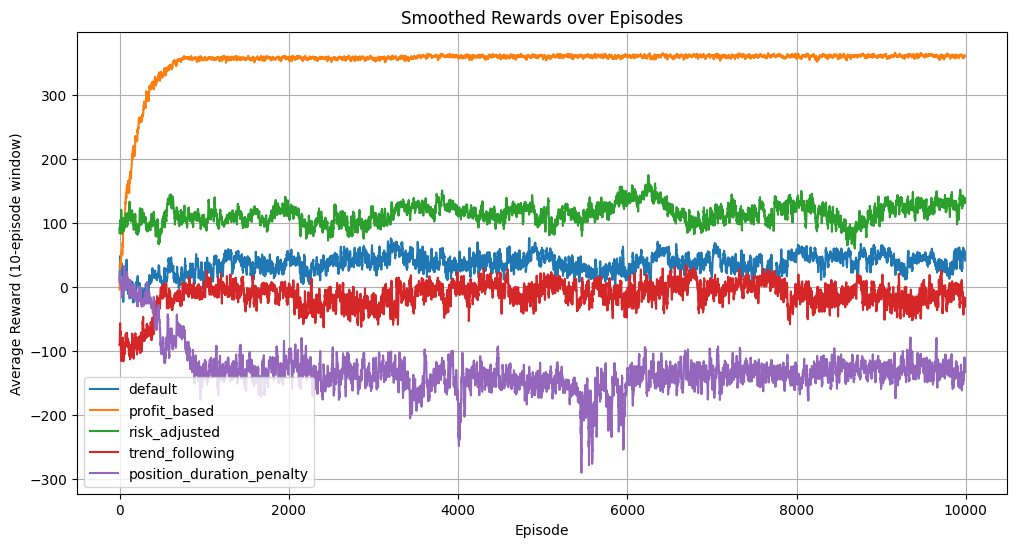

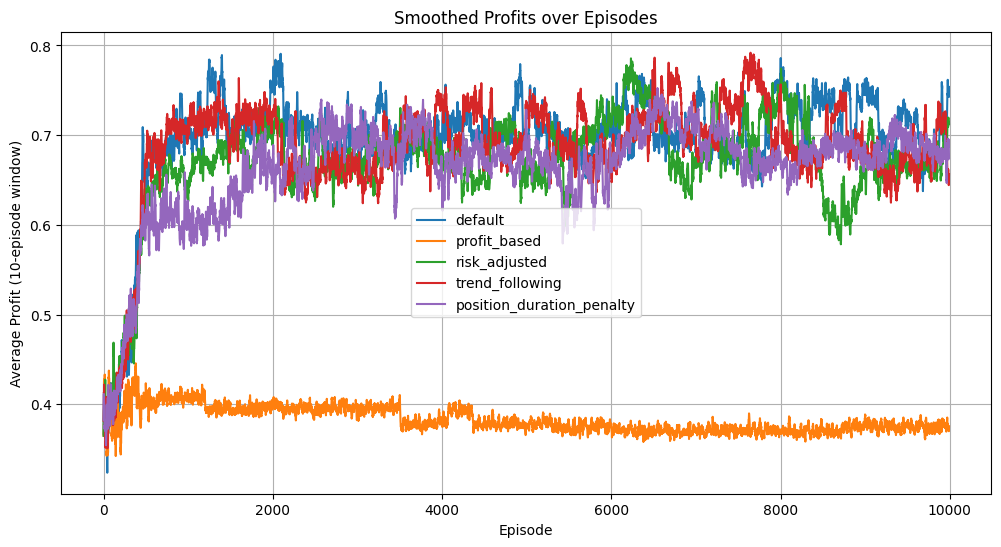

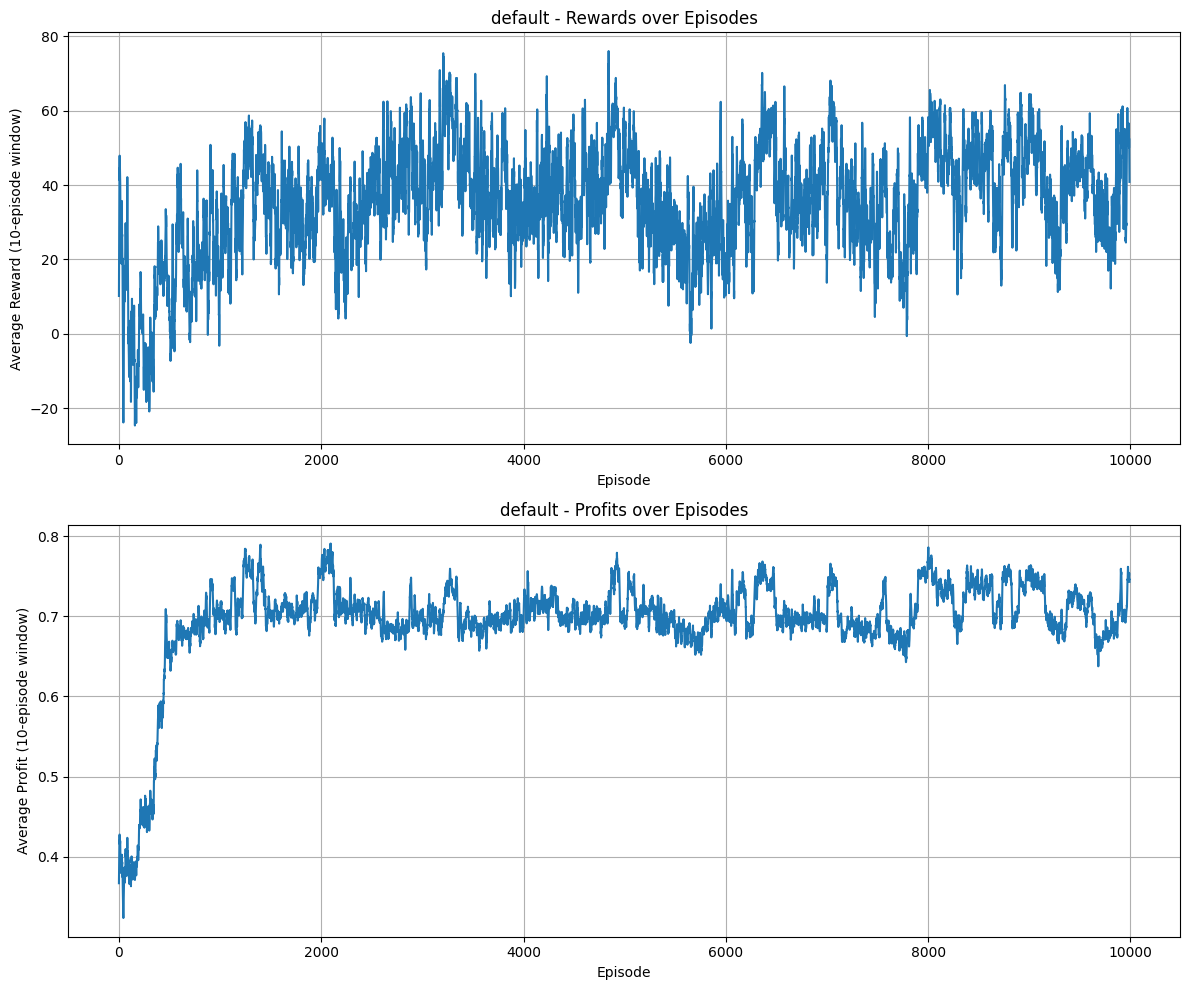

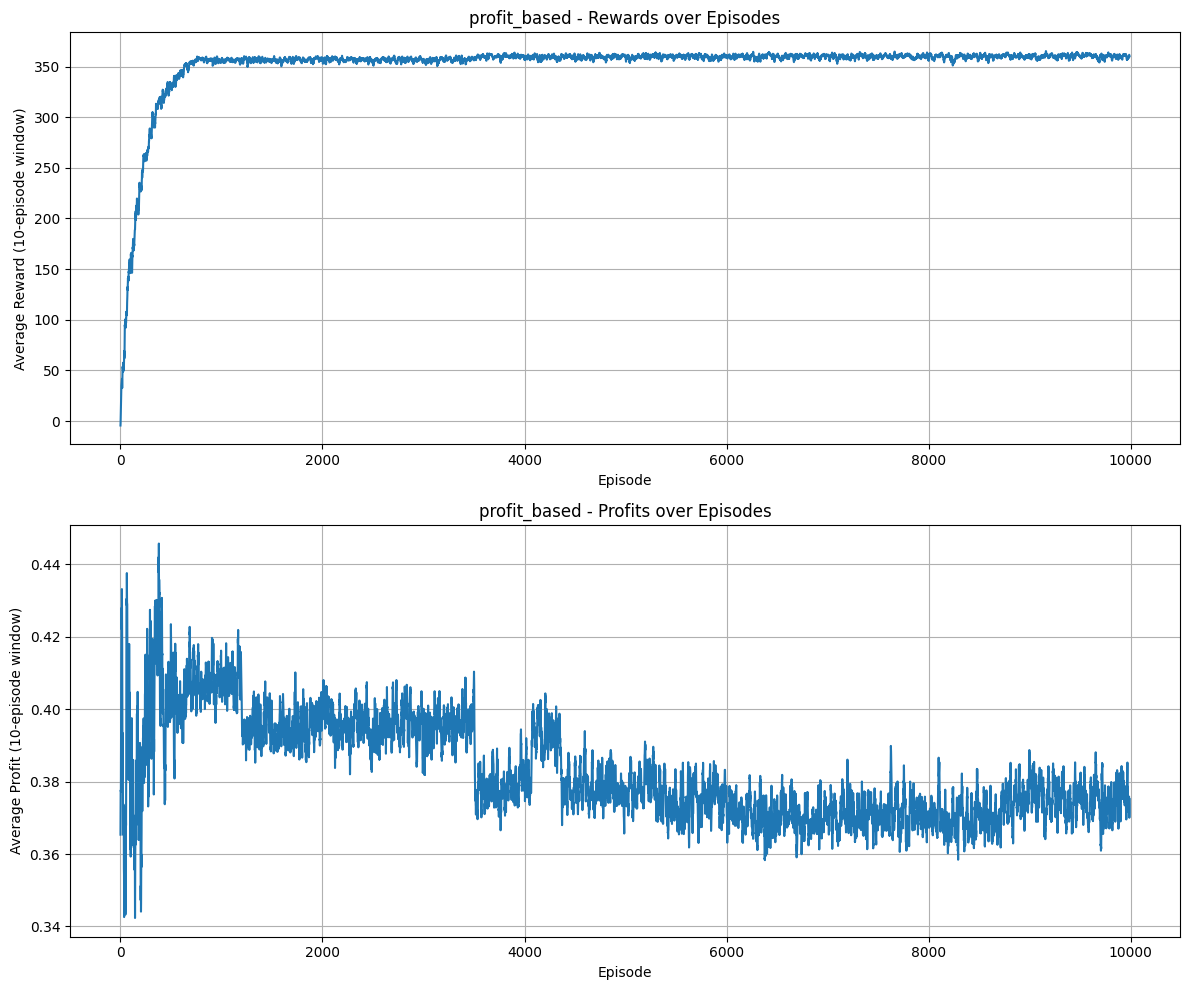

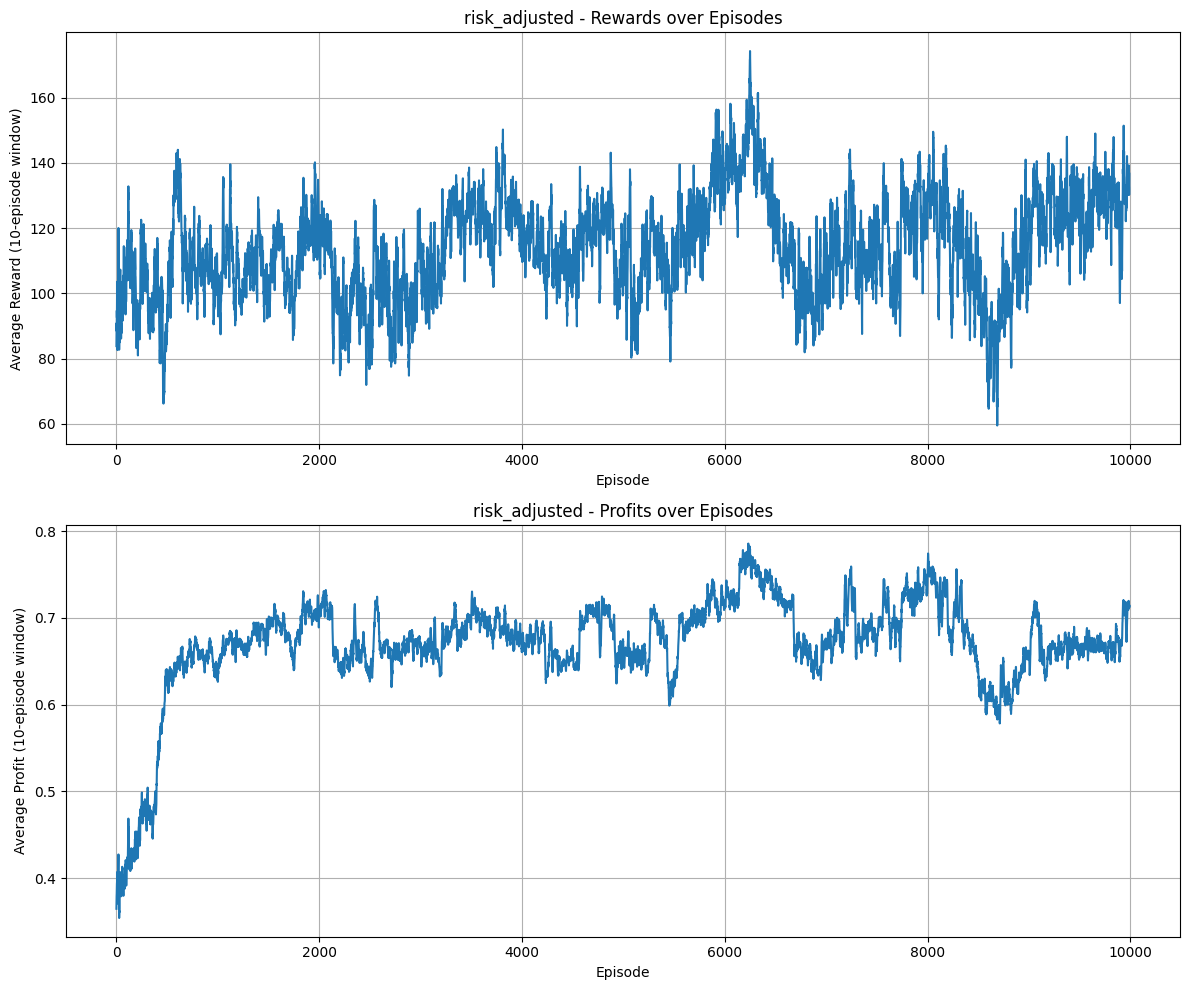

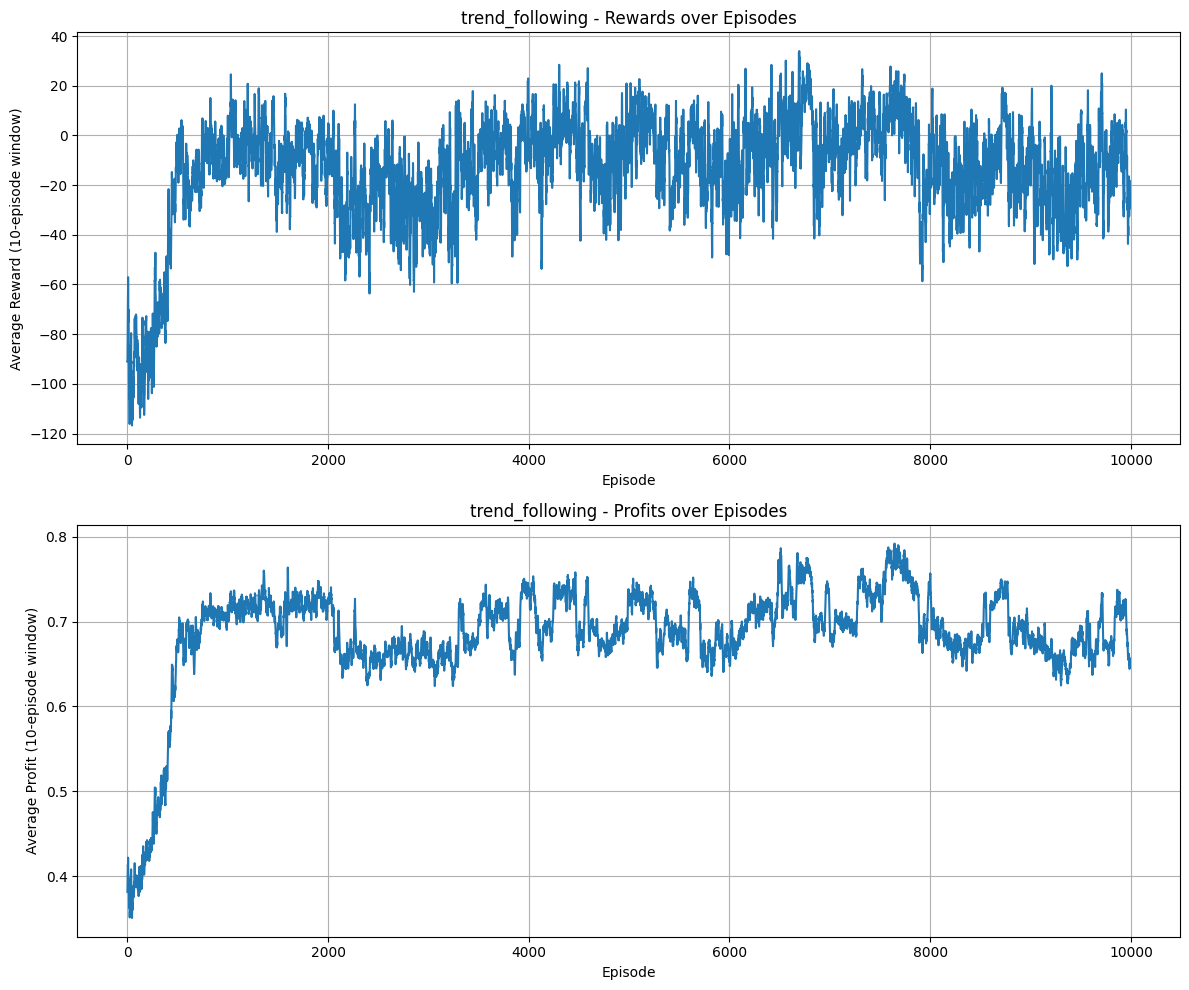

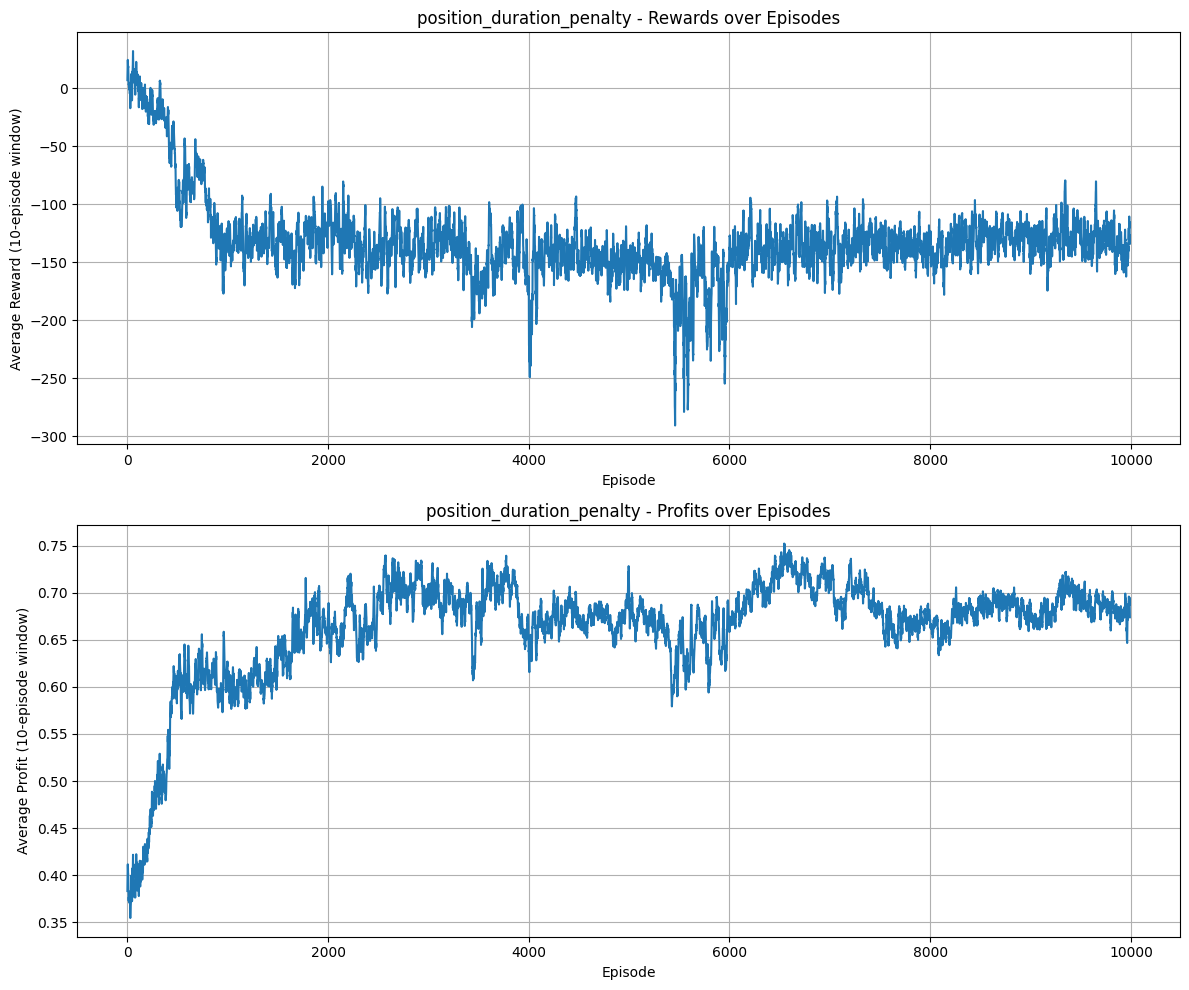


=== Final Performance Metrics (Last 100 Episodes) ===

                           avg_reward  avg_profit  max_profit  min_profit  \
default                     46.009331    0.721586    0.833904    0.635604   
profit_based               359.711365    0.376425    0.412869    0.344418   
risk_adjusted              128.797653    0.696769    0.757366    0.598188   
trend_following            -13.679966    0.695149    0.771317    0.582392   
position_duration_penalty -138.566559    0.678669    0.728764    0.597875   

                           std_profit  sharpe_ratio  
default                      0.037430     -7.438059  
profit_based                 0.015447    -40.364971  
risk_adjusted                0.032209     -9.414305  
trend_following              0.037113     -8.213918  
position_duration_penalty    0.029493    -10.894789  

Best reward structure based on Sharpe ratio: default

=== Test Performance ===

total_reward: 4.1292
final_profit: 0.7473
max_profit: 1.0059


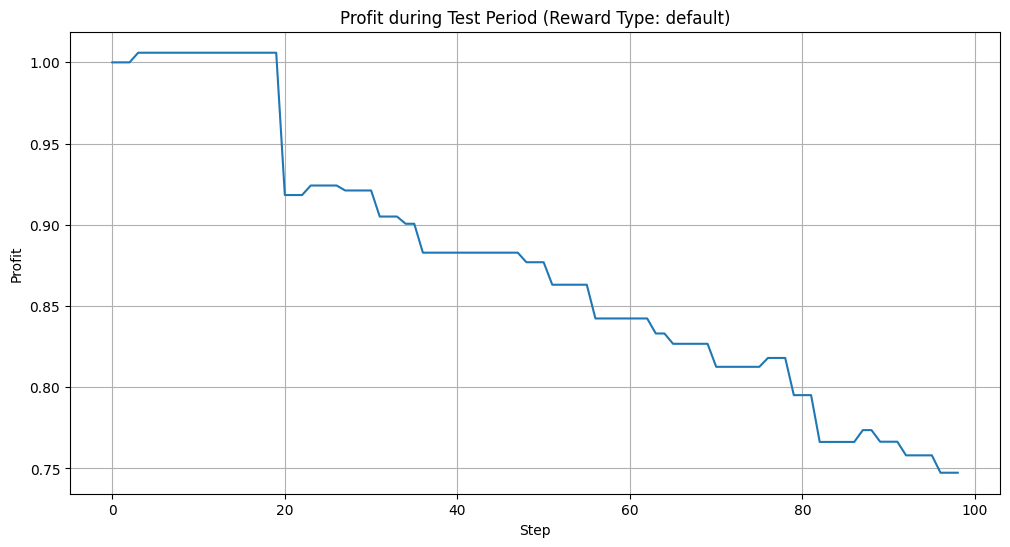

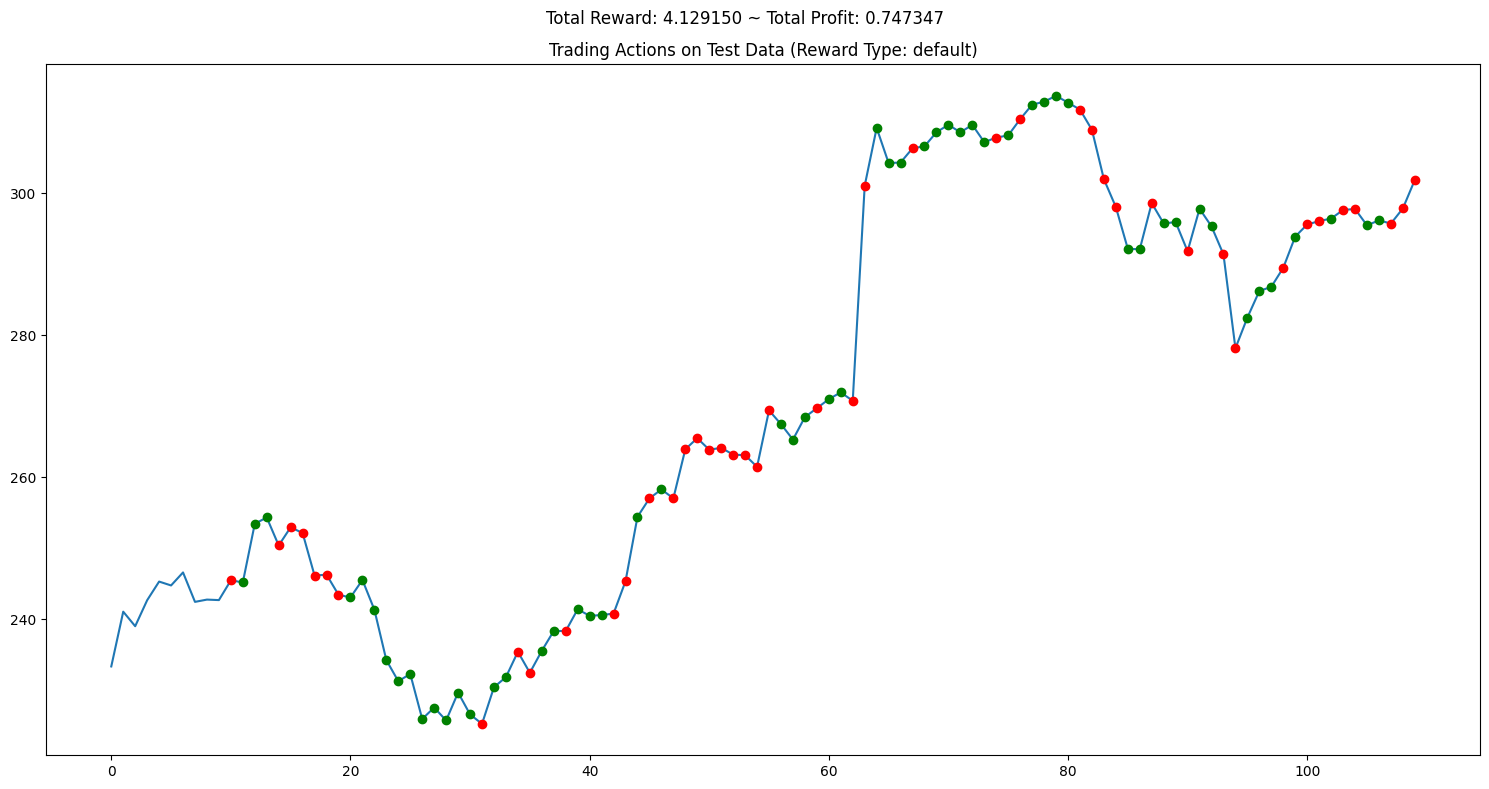

In [5]:
class RewardWrapper:
    """
    A wrapper class to modify the reward structure of the trading environment
    """
    def __init__(self, env, reward_type='default'):
        """
        Initialize the reward wrapper
        
        Args:
            env: The trading environment
            reward_type: Type of reward structure to use
        """
        self.env = env
        self.reward_type = reward_type
        self.price_history = []
        self.position_duration = 0
        self.last_position = None
        
    def reset(self):
        """Reset the wrapper state"""
        observation, info = self.env.reset()
        self.price_history = []
        self.position_duration = 0
        self.last_position = None
        return observation, info
    
    def step(self, action):
        """
        Take a step in the environment and modify the reward
        
        Args:
            action: The action to take
            
        Returns:
            Modified (observation, reward, done, info) tuple
        """
        observation, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        
        # Store current price
        current_price = self.env.unwrapped.prices[self.env.unwrapped._current_tick]
        self.price_history.append(current_price)
        
        # Track position duration
        current_position = self.env.unwrapped._position
        if self.last_position is None:
            self.last_position = current_position
        
        if current_position == self.last_position:
            self.position_duration += 1
        else:
            self.position_duration = 0
            self.last_position = current_position
        
        # Calculate modified reward based on the selected reward type
        modified_reward = self._calculate_reward(reward, action, info, done)
        
        return observation, modified_reward, terminated, truncated, info
    
    def _calculate_reward(self, original_reward, action, info, done):
        """
        Calculate the modified reward based on the selected reward type
        
        Args:
            original_reward: The original reward from the environment
            action: The action taken
            info: Additional information from the environment
            done: Whether the episode is done
            
        Returns:
            The modified reward
        """
        if self.reward_type == 'default':
            return original_reward
        
        elif self.reward_type == 'profit_based':
            # Reward based on profit percentage
            if 'total_profit' in info and len(self.price_history) > 1:
                # Calculate profit percentage since last step
                if len(self.price_history) >= 2:
                    prev_profit = (self.price_history[-2] / self.price_history[0]) if self.env.unwrapped._position == Positions.Long else (2 - self.price_history[-2] / self.price_history[0])
                    curr_profit = (self.price_history[-1] / self.price_history[0]) if self.env.unwrapped._position == Positions.Long else (2 - self.price_history[-1] / self.price_history[0])
                    profit_change = (curr_profit - prev_profit) * 100  # Convert to percentage
                    return profit_change
            return original_reward
        
        elif self.reward_type == 'risk_adjusted':
            # Risk-adjusted reward (Sharpe ratio inspired)
            if len(self.price_history) > 10:
                # Calculate returns - fix the shape mismatch
                prices = np.array(self.price_history[-10:])
                prev_prices = np.array(self.price_history[-11:-1])
                returns = (prices - prev_prices) / prev_prices
                
                # Calculate mean and std of returns
                mean_return = np.mean(returns)
                std_return = np.std(returns) + 1e-6  # Add small value to avoid division by zero
                
                # Calculate Sharpe-like ratio
                sharpe = mean_return / std_return
                
                # Combine with original reward
                return original_reward * (1 + sharpe)
            return original_reward
        
        elif self.reward_type == 'trend_following':
            # Reward that encourages following the market trend
            if len(self.price_history) > 5:
                # Calculate short-term trend
                short_trend = np.mean(np.diff(self.price_history[-5:]))
                
                # Reward for following trend
                if (short_trend > 0 and self.env.unwrapped._position == Positions.Long) or \
                    (short_trend < 0 and self.env.unwrapped._position == Positions.Short):
                        return original_reward * 1.5  # Bonus for following trend
                else:
                    return original_reward * 0.5  # Penalty for going against trend
            return original_reward
        
        elif self.reward_type == 'position_duration_penalty':
            # Penalize holding positions for too long
            duration_penalty = 0.05 * self.position_duration  # 5% penalty per step
            return original_reward - duration_penalty
        
        else:
            return original_reward

## 4. Training and Evaluation Function

def train_and_evaluate(env, reward_type, num_episodes=1000, learning_rate=0.1, discount_factor=0.99, exploration_rate=1.0, exploration_decay=0.995, min_exploration_rate=0.02):
    """
    Train a Q-learning agent and evaluate its performance
    
    Args:
        env: The trading environment
        reward_type: Type of reward structure to use
        num_episodes: Number of episodes to train
        learning_rate: Learning rate for Q-learning
        discount_factor: Discount factor for future rewards
        exploration_rate: Initial exploration rate
        exploration_decay: Rate at which exploration rate decays
        min_exploration_rate: Minimum exploration rate
        
    Returns:
        Tuple of (rewards_history, profits_history, trained_agent)
    """
    # Create reward wrapper
    wrapped_env = RewardWrapper(env, reward_type=reward_type)
    
    # Get observation space dimensions
    observation_shape = env.observation_space.shape
    
    # Define discretization parameters
    # For price values (first column)
    price_lower = 190  # Based on GOOGL data minimum
    price_upper = 320  # Based on GOOGL data maximum
    price_bins = 20    # Number of bins
    
    # For price differences (second column)
    diff_lower = -20   # Adjusted for GOOGL data
    diff_upper = 20    # Adjusted for GOOGL data
    diff_bins = 20     # Number of bins
    
    # Create discretizer with appropriate dimensions for the last row of observation
    lower_bounds = np.array([price_lower, diff_lower])
    upper_bounds = np.array([price_upper, diff_upper])
    num_bins = np.array([price_bins, diff_bins])
    
    discretizer = Discretizer(lower_bounds, upper_bounds, num_bins)
    
    # Create Q-learning agent
    agent = QLearningAgent(
        env.action_space,
        discretizer,
        learning_rate=learning_rate,
        discount_factor=discount_factor,
        exploration_rate=exploration_rate,
        exploration_decay=exploration_decay,
        min_exploration_rate=min_exploration_rate
    )
    
    # Training loop
    rewards_history = []
    profits_history = []
    
    for episode in range(1, num_episodes + 1):
        # Reset environment
        observation, info = wrapped_env.reset()
        done = False
        episode_reward = 0
        
        # Episode loop
        while not done:
            # Choose action
            action = agent.get_action(observation)
            
            # Take action
            next_observation, reward, terminated, truncated, info = wrapped_env.step(action)
            done = terminated or truncated
            
            # Update Q-table
            agent.update(observation, action, reward, next_observation, done)
            
            # Update current observation
            observation = next_observation
            
            # Accumulate reward
            episode_reward += reward
        
        # Store episode results
        rewards_history.append(episode_reward)
        profits_history.append(info['total_profit'])
        
        # Print progress
        if episode % 10 == 0:
            avg_reward = np.mean(rewards_history[-10:])
            avg_profit = np.mean(profits_history[-10:])
            print(f"Episode {episode}/{num_episodes}, Avg Reward: {avg_reward:.2f}, Avg Profit: {avg_profit:.4f}, Exploration Rate: {agent.exploration_rate:.4f}")
    
    return rewards_history, profits_history, agent

## 5. Experiment with Different Reward Structures

# Create environment
env = gym.make('stocks-v0', df=STOCKS_GOOGL, window_size=10, frame_bound=(10, 300))

# Define reward types to test
reward_types = ['default', 'profit_based', 'risk_adjusted', 'trend_following', 'position_duration_penalty']

# Store results
all_rewards = {}
all_profits = {}
all_agents = {}

# Train and evaluate with each reward type
for reward_type in reward_types:
    print(f"\n=== Training with {reward_type} reward structure ===\n")
    rewards, profits, agent = train_and_evaluate(
        env, 
        reward_type=reward_type,
        num_episodes=10000,
        learning_rate=0.1,
        discount_factor=0.99,
        exploration_rate=1.0,
        exploration_decay=0.995,
        min_exploration_rate=0.02
    )
    
    all_rewards[reward_type] = rewards
    all_profits[reward_type] = profits
    all_agents[reward_type] = agent

## 6. Visualize and Compare Results

# Create results directory if it doesn't exist
import os
results_dir = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'results', 'reward_structures')
os.makedirs(results_dir, exist_ok=True)

# Plot rewards
plt.figure(figsize=(12, 6))
for reward_type, rewards in all_rewards.items():
    # Apply smoothing for better visualization
    smoothed_rewards = np.convolve(rewards, np.ones(10)/10, mode='valid')
    plt.plot(smoothed_rewards, label=reward_type)

plt.title('Smoothed Rewards over Episodes')
plt.xlabel('Episode')
plt.ylabel('Average Reward (10-episode window)')
plt.legend()
plt.grid(True)
# Save the rewards plot
plt.savefig(os.path.join(results_dir, 'rewards_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

# Plot profits
plt.figure(figsize=(12, 6))
for reward_type, profits in all_profits.items():
    # Apply smoothing for better visualization
    smoothed_profits = np.convolve(profits, np.ones(10)/10, mode='valid')
    plt.plot(smoothed_profits, label=reward_type)

plt.title('Smoothed Profits over Episodes')
plt.xlabel('Episode')
plt.ylabel('Average Profit (10-episode window)')
plt.legend()
plt.grid(True)
# Save the profits plot
plt.savefig(os.path.join(results_dir, 'profits_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

# Create individual plots for each reward structure
for reward_type in reward_types:
    plt.figure(figsize=(12, 10))
    
    # Plot rewards
    plt.subplot(2, 1, 1)
    smoothed_rewards = np.convolve(all_rewards[reward_type], np.ones(10)/10, mode='valid')
    plt.plot(smoothed_rewards)
    plt.title(f'{reward_type} - Rewards over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward (10-episode window)')
    plt.grid(True)
    
    # Plot profits
    plt.subplot(2, 1, 2)
    smoothed_profits = np.convolve(all_profits[reward_type], np.ones(10)/10, mode='valid')
    plt.plot(smoothed_profits)
    plt.title(f'{reward_type} - Profits over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Average Profit (10-episode window)')
    plt.grid(True)
    
    plt.tight_layout()
    # Save individual reward structure plot
    plt.savefig(os.path.join(results_dir, f'{reward_type}_performance.png'), dpi=300, bbox_inches='tight')
    plt.show()

# Calculate final performance metrics
final_metrics = {}

for reward_type in reward_types:
    # Calculate metrics on the last 100 episodes
    final_rewards = all_rewards[reward_type][-100:]
    final_profits = all_profits[reward_type][-100:]
    
    metrics = {
        'avg_reward': np.mean(final_rewards),
        'avg_profit': np.mean(final_profits),
        'max_profit': np.max(final_profits),
        'min_profit': np.min(final_profits),
        'std_profit': np.std(final_profits),
        'sharpe_ratio': (np.mean(final_profits) - 1.0) / (np.std(final_profits) + 1e-6)  # Simplified Sharpe ratio
    }
    
    final_metrics[reward_type] = metrics

# Display final metrics
import pandas as pd
metrics_df = pd.DataFrame(final_metrics).T
print("\n=== Final Performance Metrics (Last 100 Episodes) ===\n")
print(metrics_df)

## 7. Test Best Agent on Unseen Data

# Find the best performing reward structure based on Sharpe ratio
best_reward_type = max(final_metrics, key=lambda x: final_metrics[x]['sharpe_ratio'])
print(f"\nBest reward structure based on Sharpe ratio: {best_reward_type}")

# Create a test environment with unseen data
test_env = gym.make('stocks-v0', df=STOCKS_GOOGL, window_size=10, frame_bound=(300, 400))

# Get the best agent
best_agent = all_agents[best_reward_type]

# Evaluate on test data
observation, info = test_env.reset()
done = False
test_rewards = []
test_profits = []

while not done:
    # Discretize the observation
    state = best_agent.discretizer.discretize(observation)
    
    # Choose the best action from Q-table (no exploration)
    if state in best_agent.q_table:
        action = np.argmax(best_agent.q_table[state])
    else:
        action = test_env.action_space.sample()
    
    # Take action
    observation, reward, terminated, truncated, info = test_env.step(action)
    done = terminated or truncated
    
    # Store results
    test_rewards.append(reward)
    if 'total_profit' in info:
        test_profits.append(info['total_profit'])

# Calculate test performance
test_performance = {
    'total_reward': sum(test_rewards),
    'final_profit': test_profits[-1] if test_profits else 0,
    'max_profit': max(test_profits) if test_profits else 0
}

print("\n=== Test Performance ===\n")
for metric, value in test_performance.items():
    print(f"{metric}: {value:.4f}")

# Visualize test performance
plt.figure(figsize=(12, 6))
plt.plot(test_profits)
plt.title(f'Profit during Test Period (Reward Type: {best_reward_type})')
plt.xlabel('Step')
plt.ylabel('Profit')
plt.grid(True)
plt.show()

# Render the test environment
plt.figure(figsize=(15, 8))
test_env.unwrapped.render_all()
plt.title(f'Trading Actions on Test Data (Reward Type: {best_reward_type})')
plt.tight_layout()
plt.show()